<a href="https://colab.research.google.com/github/Andrebarbosalima/Clusterizacaodedados/blob/master/Segmenta%C3%A7%C3%A3oDeClientes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Segmentação de Clientes
Neste trabalho, usaremos o banco de dados da Olist com K-means para identificar a frequência, recência e receita dos consumidores e agrupa-los em categorias de compras. Assim podemos fazer campanhas de marketing específicas, além de criar programas de recompensas para os clientes que mais consomem.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
df=pd.read_csv('BancoDeDados.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   amostra               8857 non-null   int64  
 1   id_cliente            8857 non-null   object 
 2   id_unico_cliente      8857 non-null   object 
 3   item_id               8857 non-null   int64  
 4   cep_cliente           8857 non-null   int64  
 5   cidade_cliente        8857 non-null   object 
 6   estado_cliente        8857 non-null   object 
 7   id_pedido             8857 non-null   object 
 8   status_pedido         8857 non-null   object 
 9   horario_pedido        8857 non-null   object 
 10  pedido_aprovado       8857 non-null   object 
 11  pedido_entregador     8778 non-null   object 
 12  pedido_entregue       8682 non-null   object 
 13  data_estimada         8857 non-null   object 
 14  id_vendedor           8857 non-null   object 
 15  preco                

Análise Exploratória

In [ ]:
def plot_perc(st,dados):
    plt.figure(figsize=(20,8))

    g = sns.countplot(x=st, data=dados, orient='h')
    g.set_title("Distribuição do estado dos clientes", fontsize=20)
    g.set_xlabel("Estado", fontsize=17)
    g.set_ylabel("Contagem", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/1.6,
            height + 200,
            '{:1.2f}%'.format(height/116581*100),
            ha="center", va='bottom',fontsize=12)
    g.set_ylim(0, max(sizes) * 1.1)

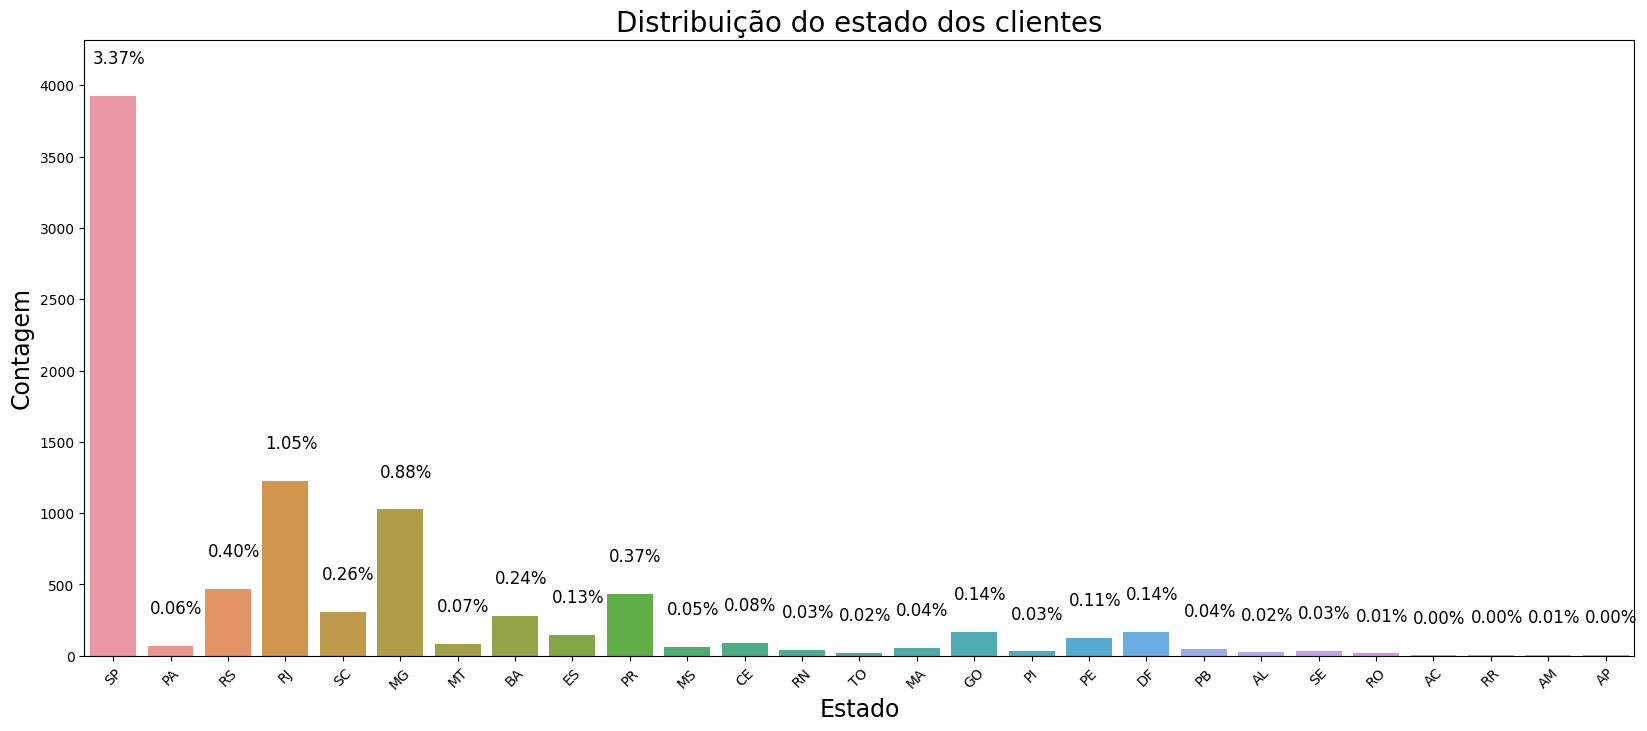

In [ ]:
plot_perc('estado_cliente',df)

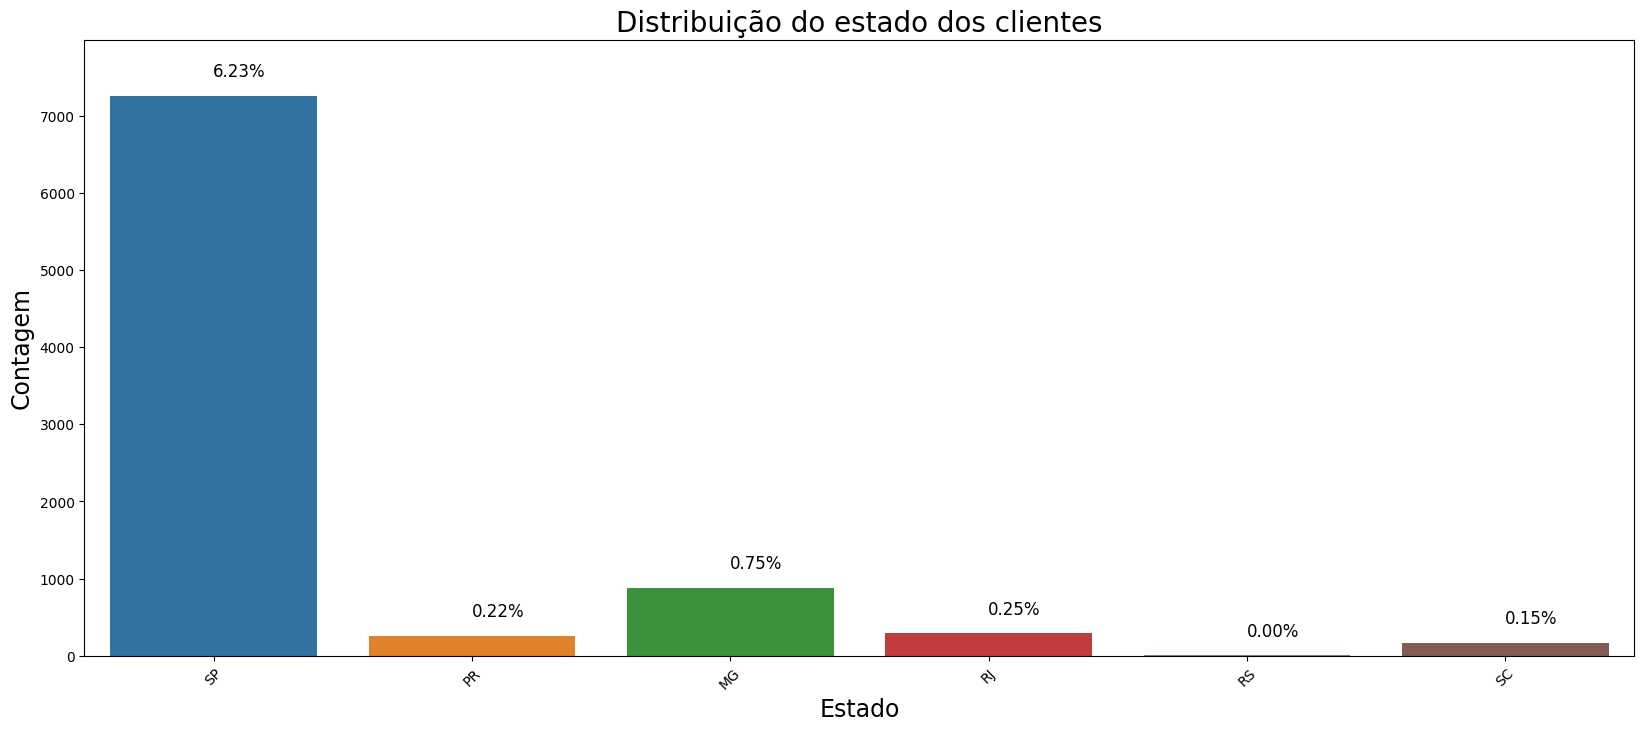

In [ ]:
plot_perc('estado_vendedor',df)

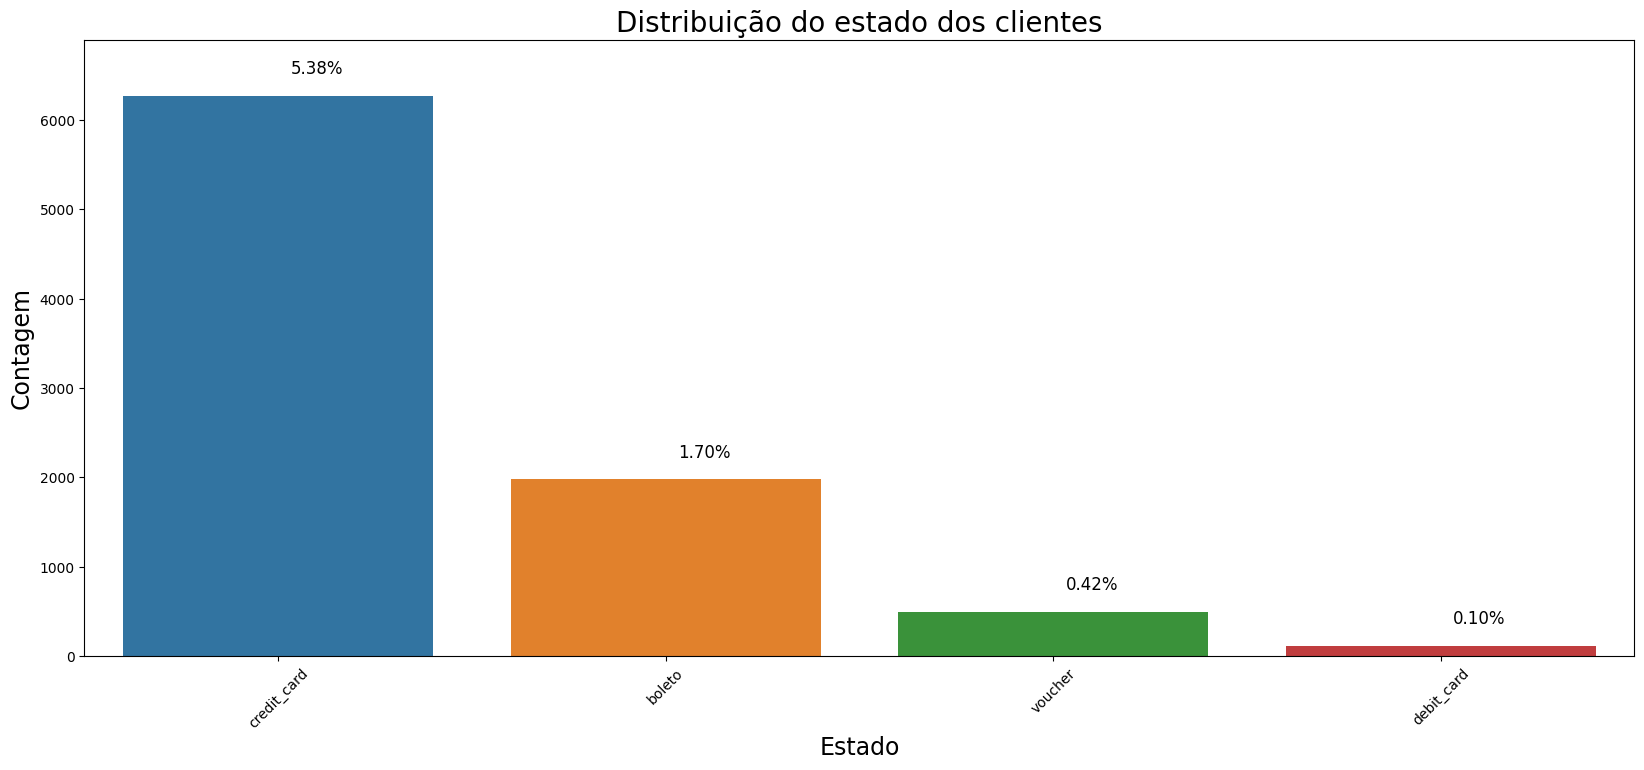

In [ ]:
plot_perc('pagamento_tipo',df)

Identificamos primeiramente que a maioria dos clientes realiza compras por cartão de crédito, posteriormente por boleto, voucher e cartão de débito. Seria interessante aumentar as promoções para pagamento à vista (para aumento dos pagamentos com boleto ou cartão de débito).
Também percebe-se que a maioria dos vendedores e compradores estão em SP.
Agora que temos um banco de dados completo, podemos salva-lo para utilizar posteriormente. Também vou criar um novo banco de dados apenas com as informações que vou precisar para fazer a análise de recẽncia, frequência e receita.

In [ ]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']]
df_olist.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99


In [ ]:
df_compra = df.groupby('id_unico_cliente').horario_pedido.max().reset_index()
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra']
df_compra.head()

,id_unico_cliente,DataMaxCompra
0,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56
1,002043098f10ba39a4600b6c52fbfe3c,2017-03-26 16:45:59
2,002471155ecd08d208d1376720e2a907,2018-08-08 20:36:30
3,0028a7d8db7b0247652509358ad8d755,2017-12-13 15:49:39
4,002cdf87d4c03f08f7eb4551a923affc,2017-10-31 17:32:22


In [ ]:
df_compra['DataMaxCompra']= pd.to_datetime(df_compra['DataMaxCompra'])
df_compra.head()

,id_unico_cliente,DataMaxCompra
0,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56
1,002043098f10ba39a4600b6c52fbfe3c,2017-03-26 16:45:59
2,002471155ecd08d208d1376720e2a907,2018-08-08 20:36:30
3,0028a7d8db7b0247652509358ad8d755,2017-12-13 15:49:39
4,002cdf87d4c03f08f7eb4551a923affc,2017-10-31 17:32:22


Precisamos definir agora as três variáveis que utilizaremos para segmentação: recência, frequência e receita. Em inglês, é chamado de método RFM. Este é um método utilizado para analisar o comportamento do cliente e definir segmentos de mercado. :

Recência: quão recentemente um cliente fez uma compra. É um importante preditor, pois um cliente que comprou há pouco tempo tem mais chance de voltar a comprar do que aquele que comprou há muito tempo, além de apresentar uma probabilidade maior de responder a promoções.
Frequência: com que frequência um cliente faz uma compra. Se um cliente compra frequentemente, espera-se que ele volte a comprar.
Receita: quanto dinheiro um cliente gasta em compras. Aqueles clientes que gastaram muito têm mais valor para a organização em comparação com aqueles que gastaram menos

In [ ]:
#seleciona o ponto de observação como a data máxima de compra em nosso df
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days
df_compra.head()

,id_unico_cliente,DataMaxCompra,Recencia
0,001147e649a7b1afd577e873841632dd,2017-08-31 17:12:56,362
1,002043098f10ba39a4600b6c52fbfe3c,2017-03-26 16:45:59,520
2,002471155ecd08d208d1376720e2a907,2018-08-08 20:36:30,20
3,0028a7d8db7b0247652509358ad8d755,2017-12-13 15:49:39,258
4,002cdf87d4c03f08f7eb4551a923affc,2017-10-31 17:32:22,301


In [ ]:
#junta esse df com o nosso novo chamado df_user
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente','Recencia']], on='id_unico_cliente')

df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,469
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,293
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,293
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,478
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,206


In [ ]:
def calcular_wcss(data):
    wcss = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=data)
        data["clusters"] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

Agora precisamos usar o Método Cotovelo, a ideia é rodar o KMeans para várias quantidades diferentes de clusters e dizer qual dessas quantidades é o número ótimo de clusters. Usando a "regra do cotovelo", identificamos que a partir de 4 clusters teremos bons resultados. Vou usar 5 apenas para garantir.

O que geralmente acontece ao aumentar a quantidade de clusters no KMeans é que as diferenças entre clusters se tornam muito pequenas, e as diferenças das observações intra-clusters vão aumentando. Então é preciso achar um equilíbrio em que as observações que formam cada agrupamento sejam o mais homogêneas possível e que os agrupamentos formados sejam o mais diferentes um dos outros.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:
df_recencia = df_usuario[['Recencia']]
df_recencia.head()

,Recencia
0,469
1,293
2,293
3,478
4,206


In [ ]:
soma_quadrados = calcular_wcss(df_recencia)

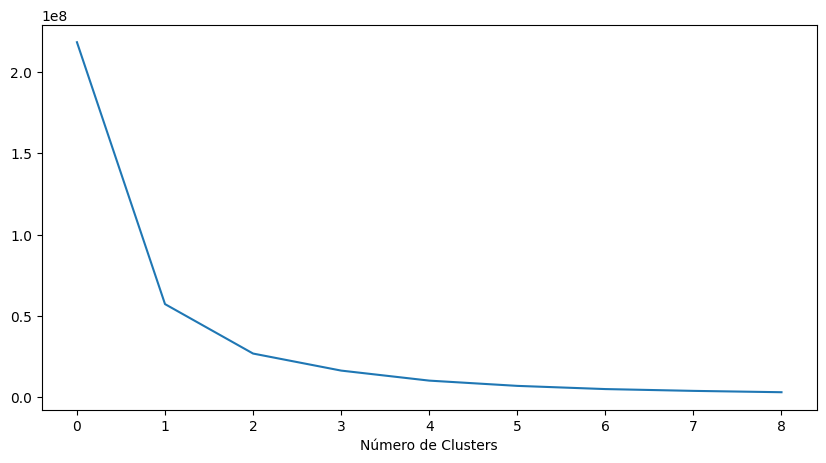

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(soma_quadrados)
plt.xlabel("Número de Clusters")
plt.show()

Mas como podemos identificar se o melhor número de clusters é 3, 4 ou 5? Existe uma solução matemática! Primeiramente, definimos uma reta ligando o primeiro ponto (cluster 1) ao último ponto (cluster 9). Então, calculamos a distância de cada ponto até a reta usando a seguinte equação:



Neste caso, P0 é o ponto do cluster 1 e P1 o ponto do cluster 9. O par (x,y) representa as coordenadas de qualquer ponto que a gente queira calcular a distância. Calculando todas as distância, conseguimos determinar o ponto ideal!

In [ ]:
import math
def numero_otimo_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distancias = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerador = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominador = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distancias.append(numerador/denominador)

    return distancias.index(max(distancias)) + 2

In [ ]:
# calculando a soma dos quadrados para as quantidade de clusters
soma_quadrados = calcular_wcss(df_recencia)

In [ ]:
# calculando a quantidade ótima de clusters
n = numero_otimo_clusters(soma_quadrados)
print(n)

4


In [ ]:
# rodando o kmeans para nossa quantidade ótima de clusters
kmeans = KMeans(n_clusters=4)
df_usuario['RecenciaCluster'] = kmeans.fit_predict(df_recencia)

In [ ]:
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,469,2
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,293,0
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,293,0
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,478,2
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,206,0


In [ ]:
#função para ordenar o número de clusters
def ordenar_cluster(cluster_nome, target_nome,df,ascending):
    novo_nome = 'novo' + cluster_nome
    agrupado_por_cluster = df.groupby(cluster_nome)[target_nome].mean().reset_index()
    agrupado_por_cluster_ordenado = agrupado_por_cluster.sort_values(by=target_nome,
                                                                     ascending=ascending).reset_index(drop=True)
    agrupado_por_cluster_ordenado['index'] = agrupado_por_cluster_ordenado.index
    juntando_cluster = pd.merge(df,agrupado_por_cluster_ordenado[[cluster_nome,'index']], on=cluster_nome)
    removendo_dados = juntando_cluster.drop([cluster_nome],axis=1)
    df_final = removendo_dados.rename(columns={"index":cluster_nome})
    return df_final

df_usuario = ordenar_cluster('RecenciaCluster', 'Recencia',df_usuario,False)

In [ ]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,1469.0,507.131382,47.406596,439.0,468.0,502.0,539.0,723.0
1,1728.0,369.739583,41.149668,296.0,336.0,374.0,406.0,438.0
2,2820.0,220.211348,41.665240,153.0,182.0,219.0,260.0,295.0
3,2840.0,84.873944,43.410193,0.0,43.0,92.0,123.0,152.0


In [ ]:
# cria um df com a quantidade de ordens para cada cliente
df_frequencia = df.groupby('id_unico_cliente').pedido_aprovado.count().reset_index()
df_frequencia.columns = ['id_unico_cliente','Frequencia']
df_frequencia.head()

,id_unico_cliente,Frequencia
0,001147e649a7b1afd577e873841632dd,2
1,002043098f10ba39a4600b6c52fbfe3c,1
2,002471155ecd08d208d1376720e2a907,1
3,0028a7d8db7b0247652509358ad8d755,2
4,002cdf87d4c03f08f7eb4551a923affc,1


In [ ]:
# adiciona esses dados em nosso df principal
df_usuario = pd.merge(df_usuario, df_frequencia, on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,469,0,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,478,0,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,523,0,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,470,0,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,528,0,1


In [ ]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_frequencia = df_usuario[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)

In [33]:
# ordena os clusters de frequência
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()


,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,7902.0,1.293850,0.549957,1.0,1.0,1.0,1.0,3.0
1,38.0,38.000000,0.000000,38.0,38.0,38.0,38.0,38.0
2,721.0,5.116505,1.077686,4.0,4.0,5.0,6.0,8.0
3,196.0,11.836735,1.967395,9.0,11.0,12.0,12.0,16.0


In [34]:
#calcula a receita para cada cliente
df_receita = df.groupby('id_unico_cliente').pagamento_valor.sum().reset_index()

#junta com o df principal
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')

In [35]:
# rodando o kmeans para nossa quantidade ótima de clusters
df_pagamento = df_usuario[['pagamento_valor']]
kmeans = KMeans(n_clusters=4)
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)

In [36]:
#ordena os clusters
df_usuario.groupby('ReceitaCluster')['pagamento_valor'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,8283.0,212.917349,238.266502,13.78,66.925,123.67,254.94,1444.16
1,43.0,20320.073256,4513.704944,14401.00,16313.600,22346.60,25051.89,25051.89
2,211.0,6341.679858,1333.026690,4663.44,5205.560,5948.36,7550.73,9212.98
3,320.0,2695.238563,891.272947,1458.60,1872.000,2632.54,3308.64,4382.50


In [37]:
df_final = df_usuario.drop(['id_cliente','horario_pedido','item_id','preco'],axis=1)
df_final.head()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,pagamento_valor,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,469,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,478,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,523,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,470,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,528,0,1,0,148.33,0


In [38]:
#renomeando as colunas
df_final.columns = ['Id_unico_cliente', 'Recencia', 'RecenciaCluster', 'Frequencia', 'FrequenciaCluster', 'Receita', 'ReceitaCluster']
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
0,861eff4711a542e4b93843c6dd7febb0,469,0,1,0,146.87,0
1,3c799d181c34d51f6d44bbbc563024db,478,0,1,0,140.61,0
2,567ab47ca4deb92d46dbf54dce07d0a7,523,0,1,0,142.05,0
3,f40ab89b622248b7ca125af4b486b887,470,0,1,0,155.70,0
4,749943913a9851a39c9baf51877fbab6,528,0,1,0,148.33,0


In [39]:
df_final = ordenar_cluster('FrequenciaCluster', 'ReceitaCluster',df_final,False)

Calcularemos a pontuação geral do cliente baseado nesses clusters e também definimos 4 opções: inativo, business, master e premium.

In [40]:
df_final['Pontuacao'] = df_usuario['RecenciaCluster'] + df_usuario['FrequenciaCluster'] + df_usuario['ReceitaCluster']
df_final.groupby('Pontuacao')['Recencia','Frequencia','Receita'].mean()
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,Receita,ReceitaCluster,FrequenciaCluster,Pontuacao
0,861eff4711a542e4b93843c6dd7febb0,469,0,1,146.87,0,2,0
1,3c799d181c34d51f6d44bbbc563024db,478,0,1,140.61,0,2,0
2,567ab47ca4deb92d46dbf54dce07d0a7,523,0,1,142.05,0,2,0
3,f40ab89b622248b7ca125af4b486b887,470,0,1,155.70,0,2,0
4,749943913a9851a39c9baf51877fbab6,528,0,1,148.33,0,2,0


In [43]:
df_final['Segmento'] = 'Inativo'
df_final.head()

,Id_unico_cliente,Recencia,RecenciaCluster,Frequencia,Receita,ReceitaCluster,FrequenciaCluster,Pontuacao,Segmento
0,861eff4711a542e4b93843c6dd7febb0,469,0,1,146.87,0,2,0,Inativo
1,3c799d181c34d51f6d44bbbc563024db,478,0,1,140.61,0,2,0,Inativo
2,567ab47ca4deb92d46dbf54dce07d0a7,523,0,1,142.05,0,2,0,Inativo
3,f40ab89b622248b7ca125af4b486b887,470,0,1,155.70,0,2,0,Inativo
4,749943913a9851a39c9baf51877fbab6,528,0,1,148.33,0,2,0,Inativo


In [44]:
df_final.loc[df_final['Pontuacao']>=3,'Segmento'] = 'Business'
df_final.loc[df_final['Pontuacao']>=6,'Segmento'] = 'Master'
df_final.loc[df_final['Pontuacao']>=8,'Segmento'] = 'Premium'

In [45]:
#salvando o banco de dados
df_final.to_csv('RFM.csv')

In [46]:
def plot_segmento(x,y,data):
    sns.set(palette='muted', color_codes=True, style='whitegrid')
    fig, axs = plt.subplots(1, 1, figsize=(7, 5))
    sns.despine(left=True)
    sns.scatterplot(x=x, y=y, hue='Segmento', data=data, size='Segmento', sizes=(50,150), size_order=['Premium','Master','Business','Inativo'])
    axs.set_title('Segmento de Cliente')
    plt.show()

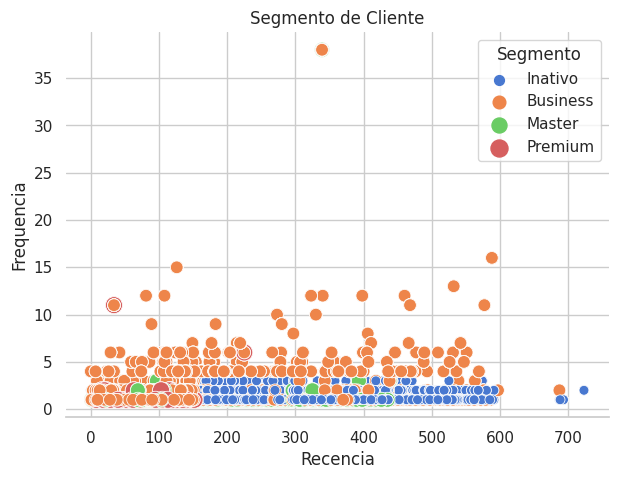

In [48]:
plot_segmento('Recencia','Frequencia',df_final)

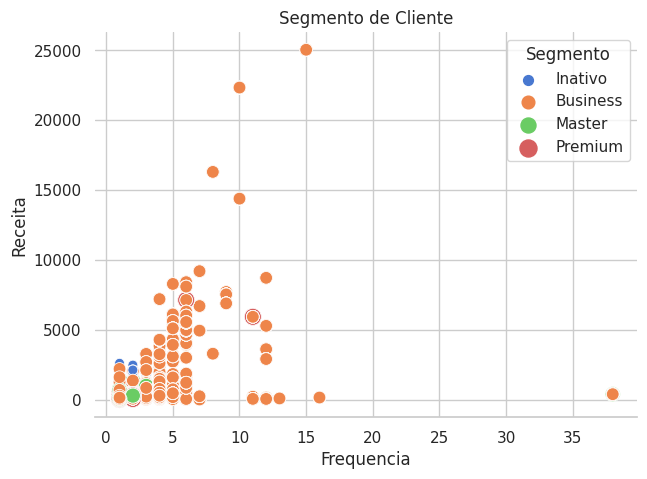

In [49]:
plot_segmento('Frequencia','Receita',df_final)

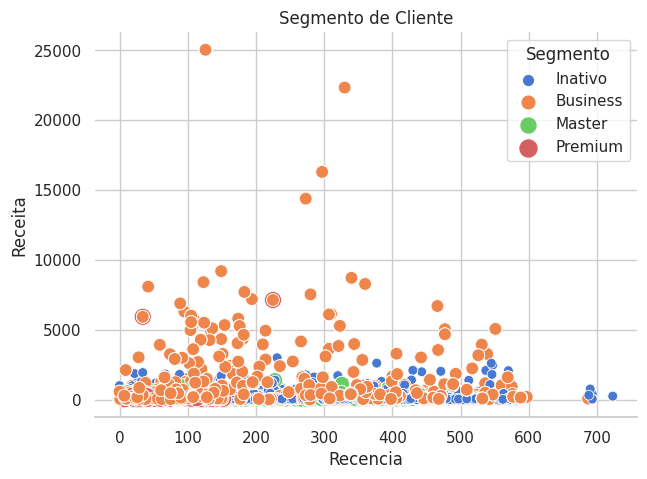

In [50]:
plot_segmento('Recencia','Receita',df_final)

<Axes: xlabel='Segmento', ylabel='count'>

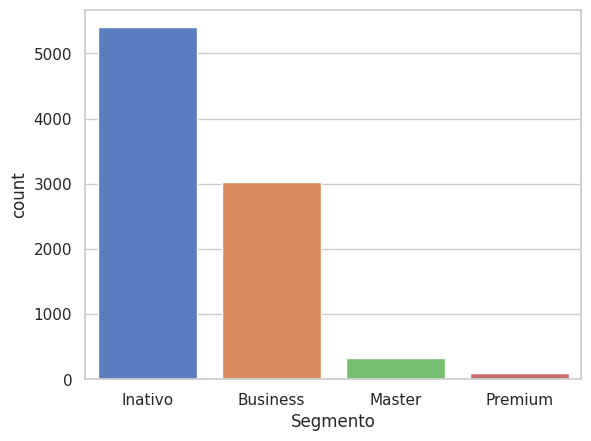

In [69]:
sns.countplot(df_final,x='Segmento')